In [2]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from utils import plot_utils
plot_utils.set_plotting_defaults()

In [3]:
# Load results of the fitting procedure

subject = 1
volume_space=False
n_from_end = 0; # if zero, load most recent; if positive, load second most recent etc.

fitting_type = 'texture_pyramid_ridge_4ori_4sf_plus_bdcn_pca_fused'

root = os.path.dirname(os.path.dirname(os.getcwd()))
if volume_space:
    folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type)
else:
    folder2load = os.path.join(root, 'model_fits','S%02d_surface'%subject, fitting_type)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = [f for f in files_in_dir if 'ipynb' not in f and 'DEBUG' not in f]
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M_%S"))
most_recent_date = my_dates[-1-n_from_end]

# most_recent_date = 'Aug-30-2021_0807_16'
# most_recent_date = 'Aug-30-2021_2008_22'
# most_recent_date = 'Jul-06-2021_0356'

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('loading from %s\n'%fullfile2load)

out = torch.load(fullfile2load)
print(out.keys())

fig_save_folder = os.path.join(root,'figures','S%02d'%subject, fitting_type, most_recent_date)
if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01_surface/texture_pyramid_ridge_4ori_4sf_plus_bdcn_pca_fused/Sep-08-2021_0027_37/all_fit_params

dict_keys(['voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'pc', 'min_pct_var', 'max_pc_to_retain', 'mult_patch_by_prf', 'do_nms', 'downsample_factor', 'feature_info'])


In [15]:
out['partial_masks'][1,:]

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
var_expl

In [16]:
def get_r2(out):
    
    val_cc = out['val_cc']
    # Note i'm NOT using the thing that actually is in the field val_r2, 
    # bc that is coefficient of determination which gives poor results for ridge regression.
    # instead using the signed squared correlation coefficient for r2/var explained.
    val_r2 = np.sign(val_cc)*val_cc**2

    return val_r2

In [10]:
out['partial_version_names']

['full_combined_model',
 'just_pyramid',
 'pyramid_just_mean_magnitudes_no_other_modules',
 'pyramid_just_all_other_texture_feats_no_other_modules',
 'pyramid_just_mean_magnitudes_plus_other_modules',
 'pyramid_just_all_other_texture_feats_plus_other_modules',
 'just_bdcn']

In [10]:
out['val_cc'][3,0:8]

array([0.19272639, 0.        , 0.        , 0.        , 0.21313943,
       0.2165984 , 0.24998665], dtype=float32)

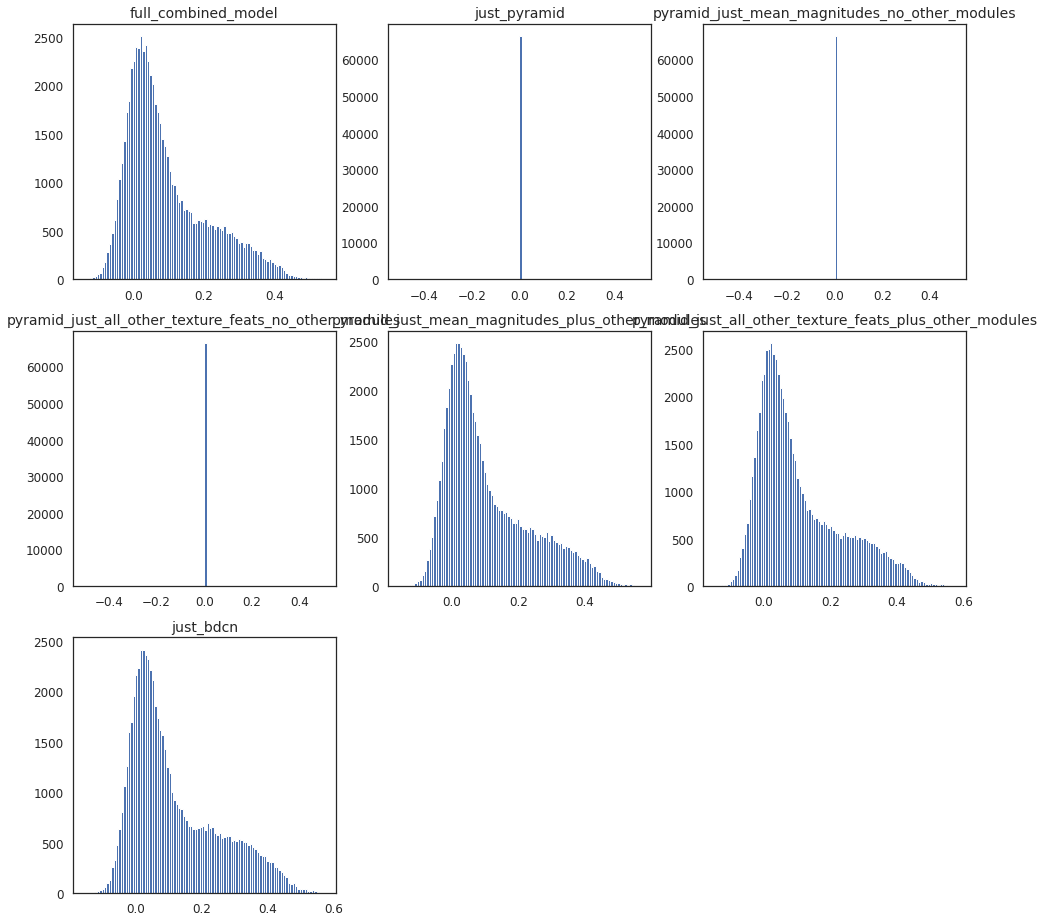

In [4]:
plt.figure(figsize=(16,16));
n_partial_versions = out['partial_masks'].shape[0]
val_cc = out['val_cc']
for ii in range(n_partial_versions):
    
    plt.subplot(3,3,ii+1)
    plt.hist(val_cc[:,ii],100)
    plt.title(out['partial_version_names'][ii])

In [24]:

n_partial_versions = out['partial_masks'].shape[0]
val_cc = out['val_cc']
val_r2 = get_r2(out)
# Compute variance explained by each feature type - how well does the model without that feature type
# do, compared to the model with all features? 
# (subtract later columns from the first column)
var_expl = np.tile(np.expand_dims(val_r2[:,0], axis=1), [1,n_partial_versions-1]) - val_r2[:,1:] 

var_expl_names = ['bdcn', 'higher order texture+bdcn', 'gabor+bdcn', 'higher order texture', 'gabor', 'texture all'] 

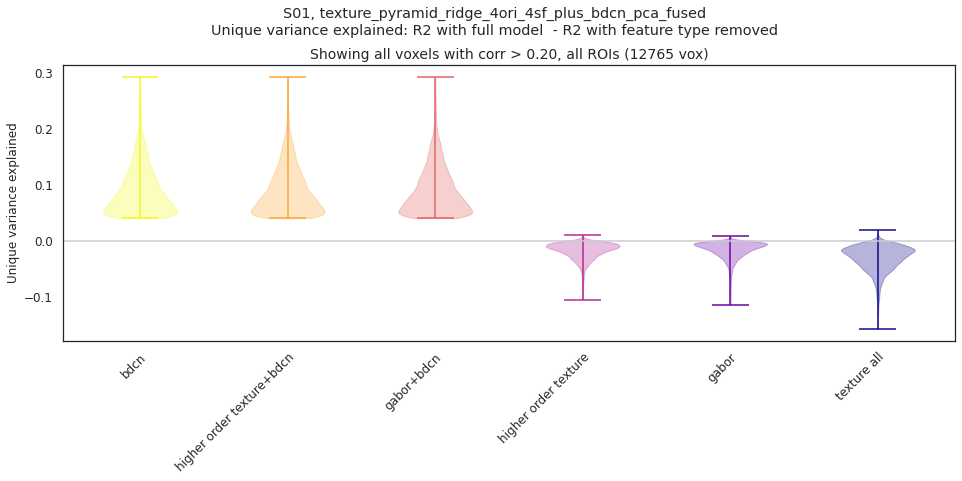

In [25]:
plt.figure(figsize=(16,8))

cc_cutoff=0.2

colors = cm.plasma(np.linspace(0,1,n_partial_versions-1))
colors = np.flipud(colors)

abv_thresh = val_cc[:,0]>cc_cutoff
inds2use = abv_thresh

for ff in range(n_partial_versions-1):

    parts = plt.violinplot(var_expl[inds2use,ff], [ff])
    for pc in parts['bodies']:
        pc.set_color(colors[ff,:])
    parts['cbars'].set_color(colors[ff,:])
    parts['cmins'].set_color(colors[ff,:])
    parts['cmaxes'].set_color(colors[ff,:])

#     plt.bar(ff, avg_ve[ff], color=colors[ff,:])

plt.xticks(ticks=np.arange(0,n_partial_versions-1),labels=var_expl_names,rotation=45, ha='right',rotation_mode='anchor')
plt.axhline(0, color=[0.8, 0.8, 0.8])
# plt.xlabel('feature type')
plt.ylabel('Unique variance explained')

plt.title('Showing all voxels with corr > %.2f, all ROIs (%d vox)'%(cc_cutoff, np.sum(inds2use)))

plt.suptitle('S%02d, %s\nUnique variance explained: R2 with full model  - R2 with feature type removed'%(subject, fitting_type))
plt.gcf().subplots_adjust(bottom=0.4)
    

In [ ]:
assert(out['val_cc'].shape[1]>1)


    roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
        n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

    feature_info = copy.deepcopy(out['feature_info'])
    feature_type_labels, feature_type_names = feature_info
    n_feature_types = len(feature_type_names)
    
   
   
    plt.figure(figsize=(16,8))
   

    colors = cm.plasma(np.linspace(0,1,n_feature_types))
    colors = np.flipud(colors)

    abv_thresh = val_cc[:,0]>cc_cutoff
    inds2use = abv_thresh

    for ff in range(n_feature_types):

        parts = plt.violinplot(var_expl[inds2use,ff], [ff])
        for pc in parts['bodies']:
            pc.set_color(colors[ff,:])
        parts['cbars'].set_color(colors[ff,:])
        parts['cmins'].set_color(colors[ff,:])
        parts['cmaxes'].set_color(colors[ff,:])

    #     plt.bar(ff, avg_ve[ff], color=colors[ff,:])

    plt.xticks(ticks=np.arange(0,n_feature_types),labels=feature_type_names,rotation=45, ha='right',rotation_mode='anchor')
    plt.axhline(0, color=[0.8, 0.8, 0.8])
    # plt.xlabel('feature type')
    plt.ylabel('Unique variance explained')

    plt.title('Showing all voxels with corr > %.2f, all ROIs (%d vox)'%(cc_cutoff, np.sum(inds2use)))

    plt.suptitle('S%02d, %s\nUnique variance explained: R2 with full model  - R2 with feature type removed'%(subject, fitting_type))
    plt.gcf().subplots_adjust(bottom=0.4)
    
    if fig_save_folder is not None:
        plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.png'))
        plt.savefig(os.path.join(fig_save_folder,'violin_uniq_var_texturefeat_allrois.pdf'))


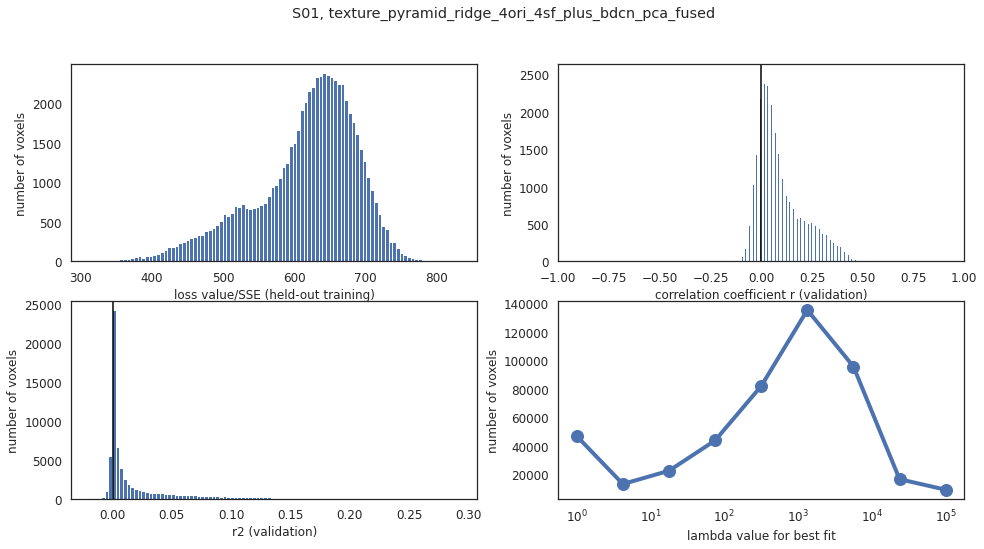

In [4]:
plot_utils.plot_perf_summary(subject, fitting_type, out, fig_save_folder=fig_save_folder)

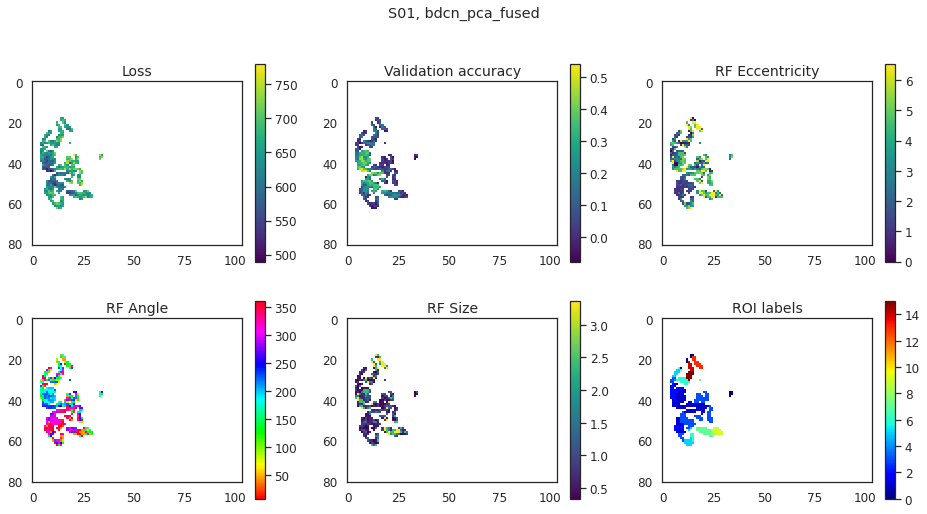

In [7]:
plot_utils.plot_fit_summary_volume_space(subject, fitting_type,out, fig_save_folder)

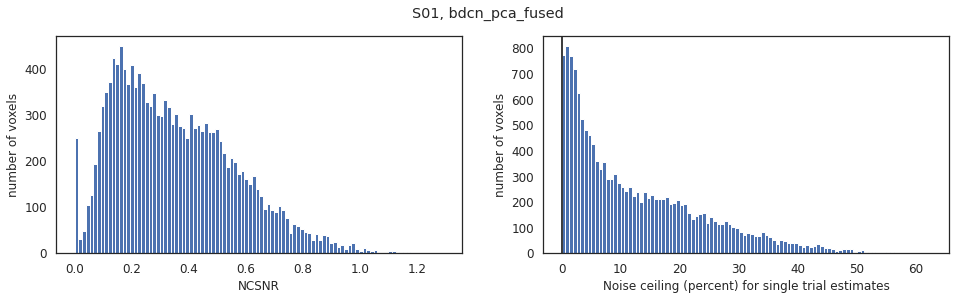

In [8]:
plot_utils.plot_noise_ceilings(subject, fitting_type,out, fig_save_folder)

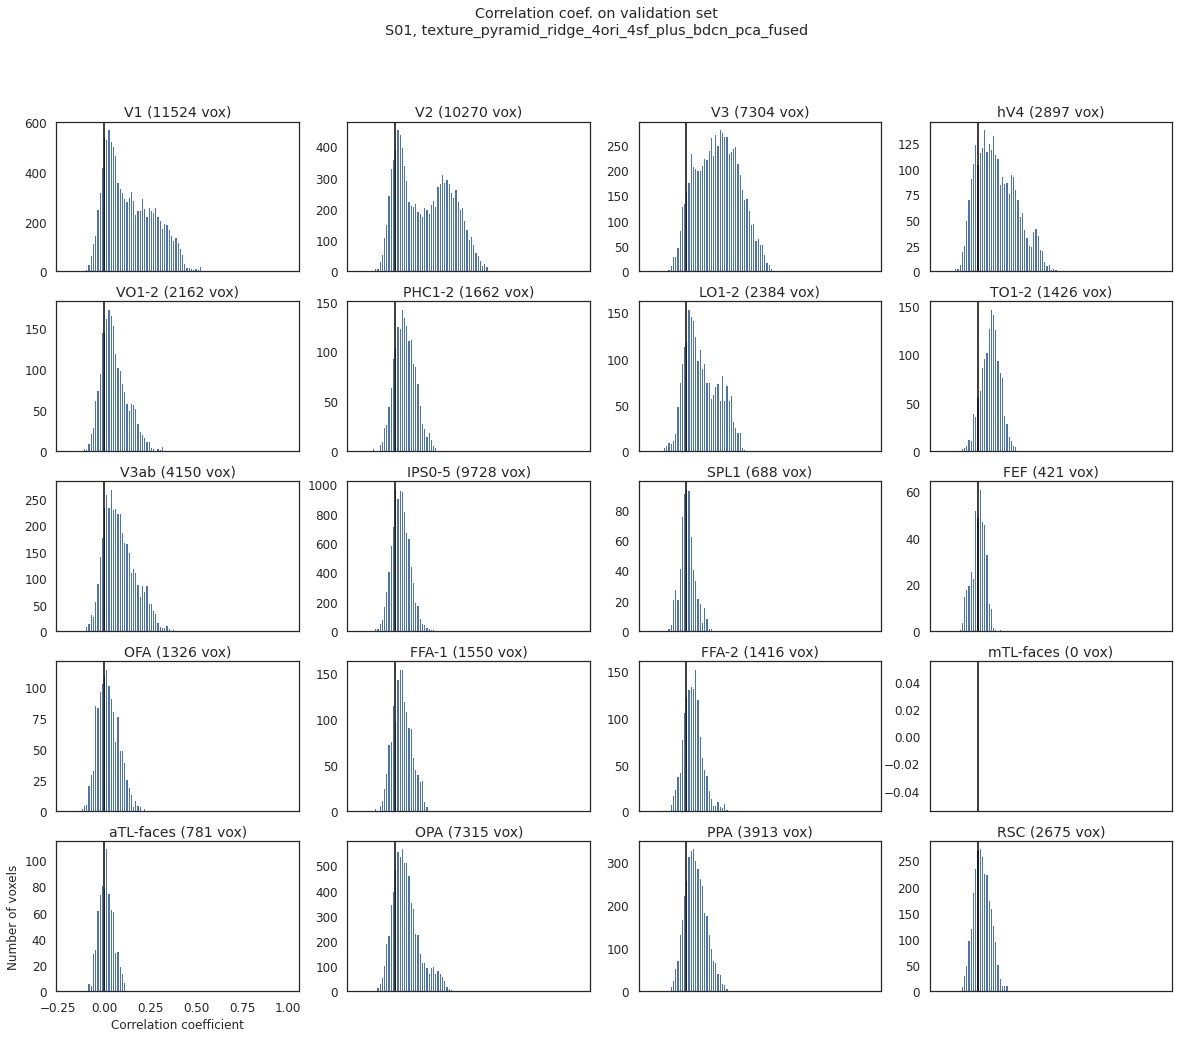

In [5]:
plot_utils.plot_cc_each_roi(subject, fitting_type,out, fig_save_folder)

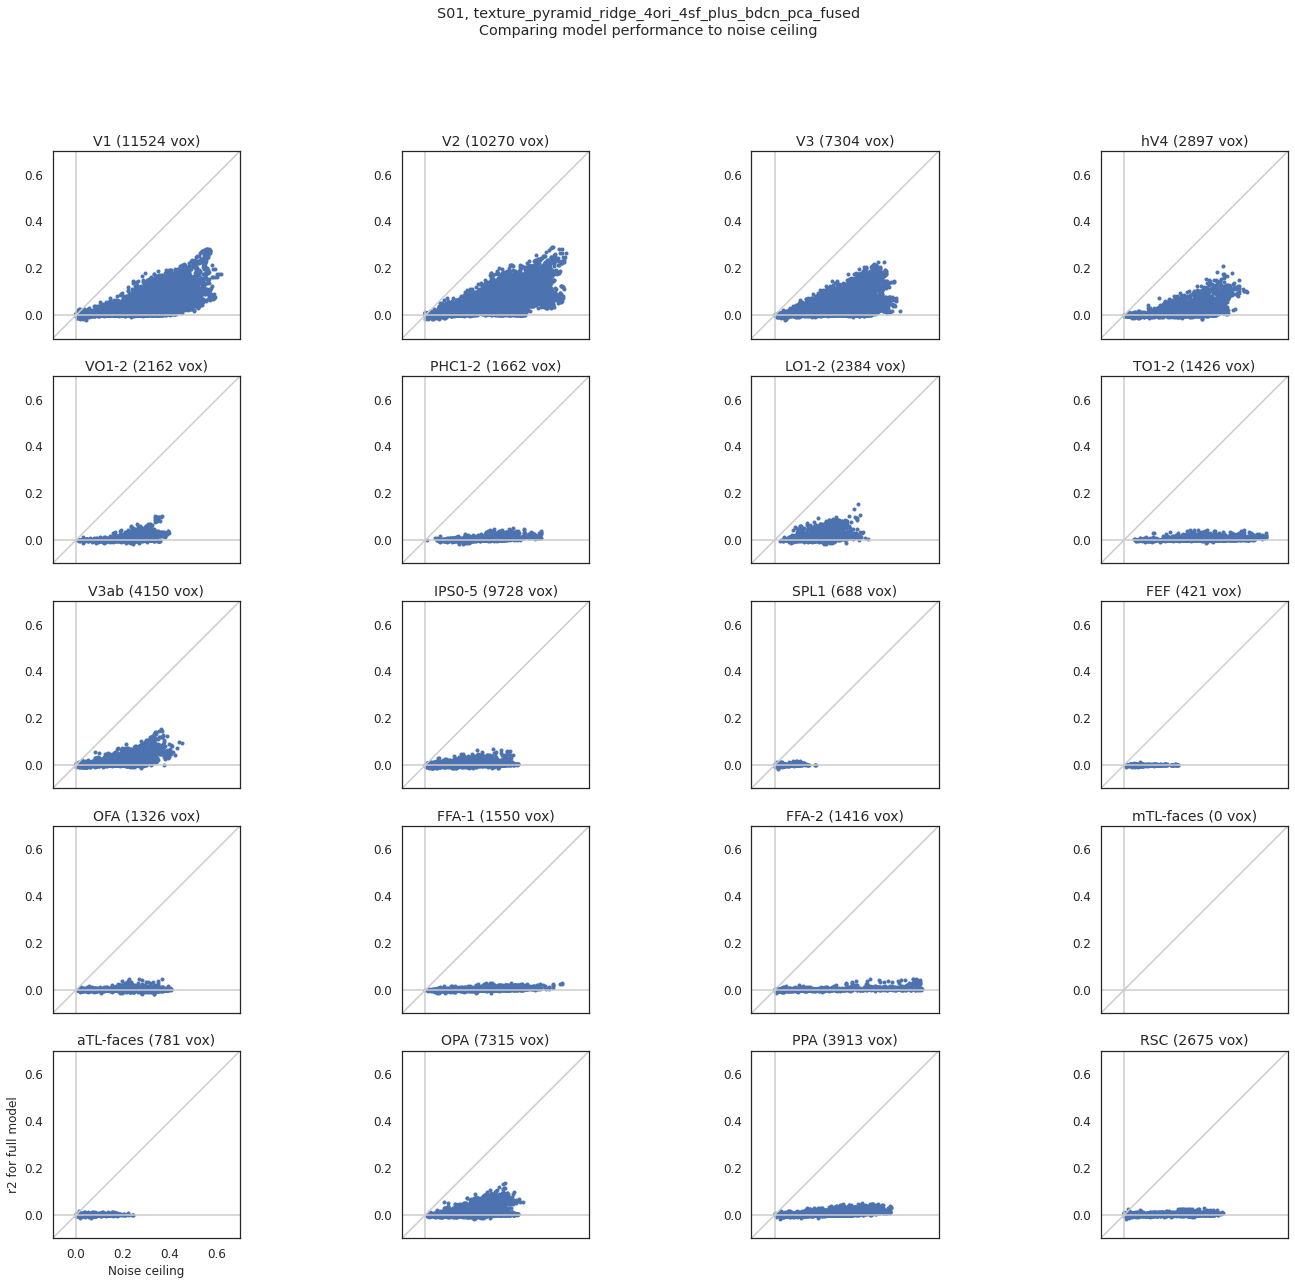

In [6]:
plot_utils.plot_r2_vs_nc(subject, fitting_type,out, fig_save_folder)

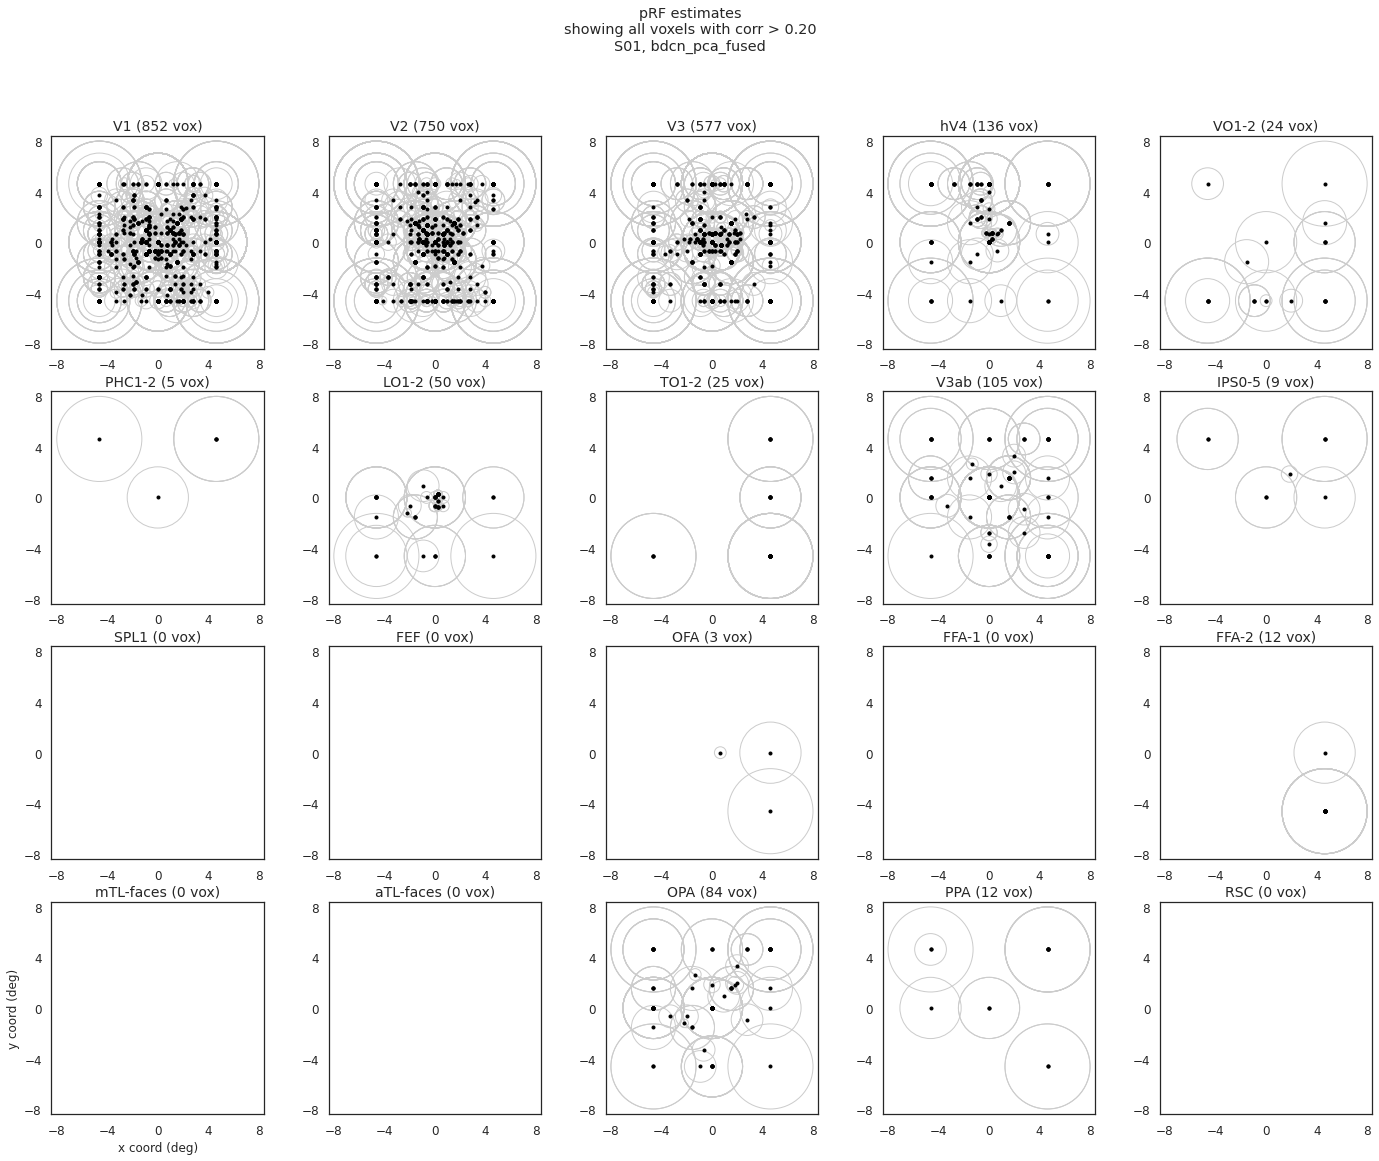

In [12]:
plot_utils.plot_spatial_rf_circles(subject, fitting_type,out, cc_cutoff = 0.20, fig_save_folder=fig_save_folder)

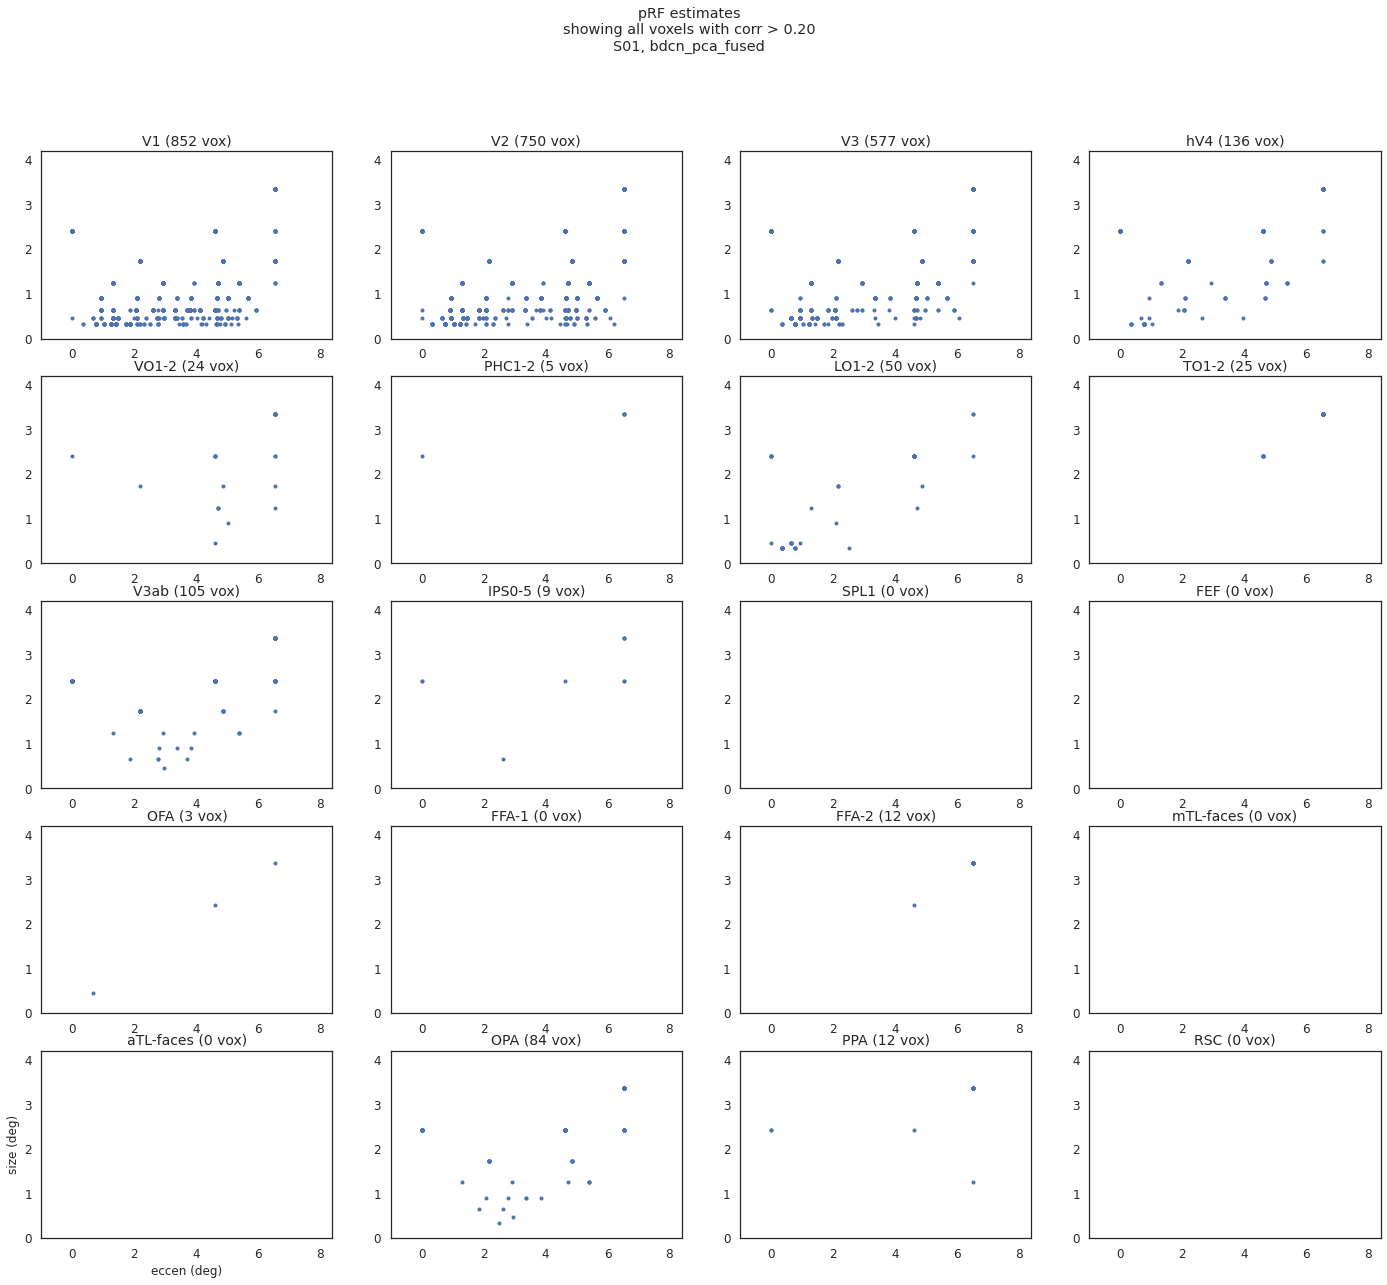

In [4]:
plot_utils.plot_size_vs_eccen(subject, fitting_type, out, cc_cutoff=0.2, fig_save_folder=fig_save_folder)

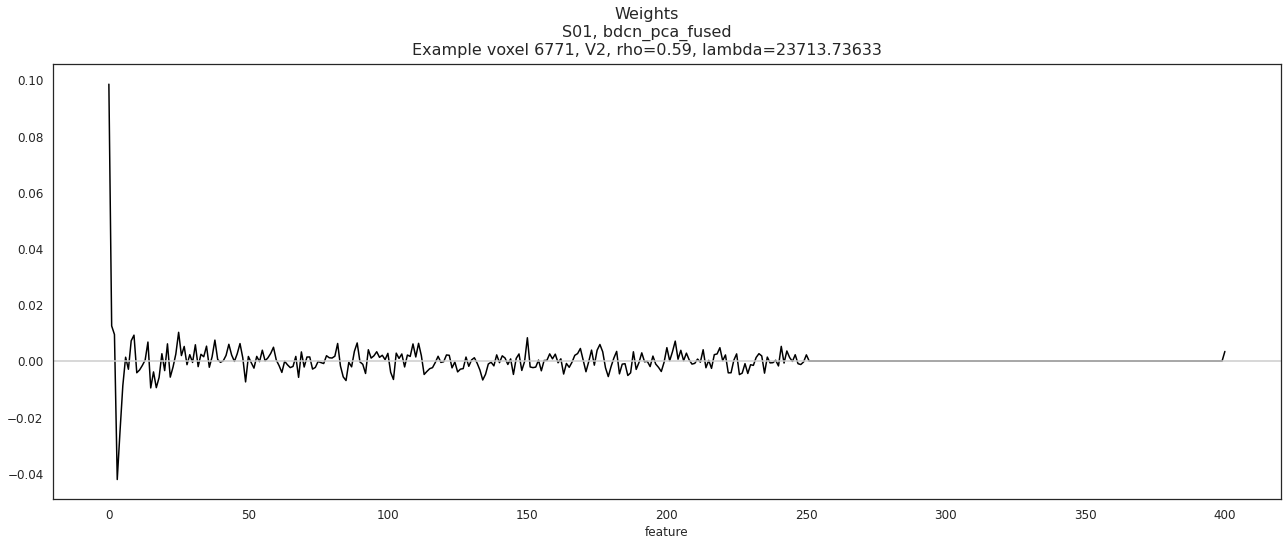

In [23]:
# Plotting some example weights...

from copy import deepcopy
roi_labels_retino, roi_labels_categ, ret_group_inds, categ_group_inds, ret_group_names, categ_group_names, \
        n_rois_ret, n_rois_categ, n_rois = plot_utils.get_roi_info(subject, out)

pp=0
val_cc = out['val_cc'][:,0]
lambdas = out['lambdas']
best_lambdas = out['best_lambdas']
vox2plot = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

vv=vox2plot

plt.figure(figsize=(22,8))

weights = out['best_params'][1]
wts = weights[vv,:]
plt.plot(wts,'-',color='k')

plt.axhline(0,color=[0.8, 0.8, 0.8])

plt.xlabel('feature')

roi_ind_ret = np.where([np.isin(roi_labels_retino[vv], ret_group_inds[ii]) for ii in range(len(ret_group_inds))])[0]
roi_ind_categ = np.where([np.isin(roi_labels_categ[vv], categ_group_inds[ii]) for ii in range(len(categ_group_inds))])[0]
if len(roi_ind_ret)==0:
    rname = categ_group_names[roi_ind_categ[0]]
elif len(roi_ind_categ)==0:
    rname = ret_group_names[roi_ind_ret[0]]
else:
    rname = '%s/%s'%(ret_group_names[roi_ind_ret[0]],categ_group_names[roi_ind_categ[0]])
    
plt.title(''%())

plt.suptitle('Weights\nS%02d, %s\nExample voxel %d, %s, rho=%.2f, lambda=%.5f'%( subject, fitting_type,vv,rname, val_cc[vv],lambdas[best_lambdas[vv]]),fontsize=16);
